In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ===============================
# SYNTHETIC DATA GENERATION (REALISTIC)
# ===============================
np.random.seed(42)
n_samples = 5000  # Increased for better generalization

# --- Financial Basics ---
average_monthly_income = np.random.randint(3000, 15000, n_samples)
average_monthly_expenses = np.random.randint(1000, 8000, n_samples)
total_assets_value = np.random.randint(1000, 50000, n_samples)
time_horizon = np.random.choice([6, 12, 18, 24], n_samples)

# --- Loan Parameters ---
min_amount = np.random.randint(1000, 10000, n_samples)
max_amount = min_amount + np.random.randint(1000, 15000, n_samples)
interest_rate = np.random.uniform(5, 25, n_samples)
term_months = np.random.choice([6, 12, 18, 24, 36], n_samples)
loan_names = np.random.choice(['Starter Loan', 'AgriFlex', 'Business Boost'], n_samples)

# --- Derived Calculations ---
loan_amount = (min_amount + max_amount) / 2
monthly_interest_rate = interest_rate / 100 / 12
monthly_loan_payment = (loan_amount * monthly_interest_rate) / (1 - (1 + monthly_interest_rate) ** -term_months)
total_repayment = monthly_loan_payment * term_months
monthly_surplus = average_monthly_income - average_monthly_expenses

# --- Time-Aware Savings Calculation ---
term_mask = term_months <= time_horizon

savings_during_loan = (monthly_surplus - monthly_loan_payment) * term_months
savings_after_loan = monthly_surplus * (time_horizon - term_months)
net_loan_effect = loan_amount - total_repayment

savings_short_term = (monthly_surplus - monthly_loan_payment) * time_horizon
net_loan_effect_short = loan_amount - (monthly_loan_payment * time_horizon)

achievable_savings = np.where(
    term_mask,
    savings_during_loan + savings_after_loan + net_loan_effect,
    savings_short_term + net_loan_effect_short
)

# --- Target Variable ---
target_savings = np.random.randint(5000, 50000, n_samples)
savings_margin = achievable_savings - target_savings

# --- Feature Engineering ---
df_train = pd.DataFrame({
    'monthly_income': average_monthly_income,
    'monthly_expenses': average_monthly_expenses,
    'existing_assets': total_assets_value,
    'interest_rate': interest_rate,
    'loan_amount': loan_amount,
    'term_months': term_months,
    'time_horizon': time_horizon,
    'loan_names': loan_names,
    'loan_to_income': loan_amount / average_monthly_income,
    'interest_cost': total_repayment - loan_amount,
    'cash_runway': total_assets_value / np.clip(monthly_surplus, 1, None),  # Fixed line
    'savings_margin': savings_margin
})

# Remove negative infinities from cash_runway
df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna()

# --- Split Data ---
X = df_train.drop(columns=['savings_margin'])
y = df_train['savings_margin']

# --- Model Pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ('loan_names', OneHotEncoder(), ['loan_names'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# --- Hyperparameter Tuning ---
param_grid = {
    'regressor__max_depth': [None, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__max_features': ['sqrt', 0.8]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)

# --- Evaluation ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.0f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):,.0f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

Best Parameters: {'regressor__max_depth': 20, 'regressor__max_features': 0.8, 'regressor__min_samples_split': 2}
MAE: 12148
MSE: 205,180,101
R²: 0.961


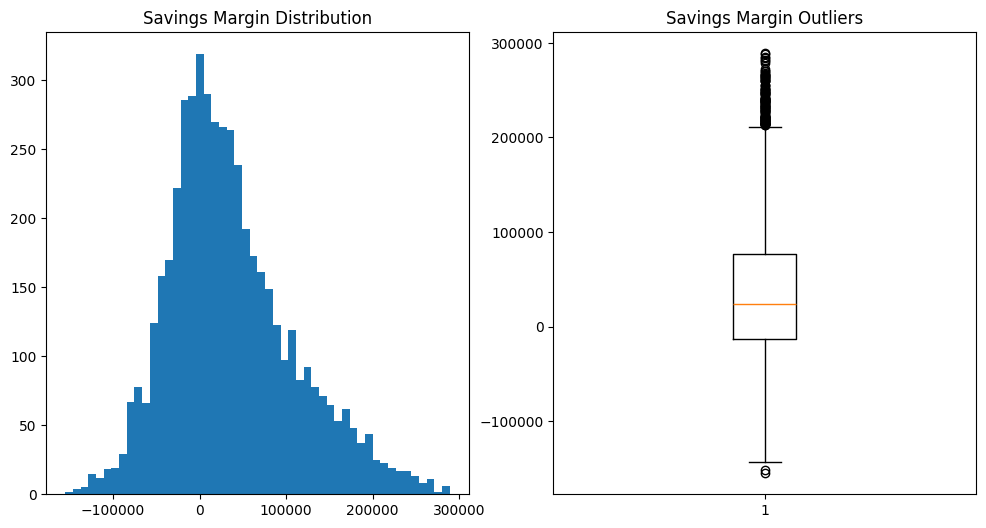

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y, bins=50)
plt.title('Savings Margin Distribution')

plt.subplot(1, 2, 2)
plt.boxplot(y)
plt.title('Savings Margin Outliers')
plt.show()

# Apply Winsorizing if needed
from scipy.stats.mstats import winsorize
y_processed = winsorize(y, limits=[0.05, 0.05])

In [13]:
# --- Prepare Input Data for Predictions ---
# --- Step 1: Define the Constant User Financial Profile ---
user_profile = {
    'total_assets_value': 25000,
    'average_monthly_income': 12000,
    'average_monthly_expenses': 4000,
    'target_savings': 30000,
    'time_horizon': 12  # Example: 12 months
}

# --- Step 2: Define Multiple Loan Options to Evaluate ---
# Each row represents one loan option candidate.
loan_options = pd.DataFrame({
    'min_amount': [5000, 7000],
    'interest_rate': [10.0, 12.5,],
    'max_amount': [8000, 10000,],
    'term_months': [2, 4,],
    'loan_names': ['Business Boost',  'AgriFlex']  # Example loan names
})
# Extract user profile data
user_monthly_income = user_profile['average_monthly_income']
user_monthly_expenses = user_profile['average_monthly_expenses']
user_existing_assets = user_profile['total_assets_value']
user_time_horizon = user_profile['time_horizon']

# Process loan options
loan_options_processed = loan_options.copy()

# Calculate derived loan features
loan_options_processed['loan_amount'] = (loan_options_processed['min_amount'] + loan_options_processed['max_amount']) / 2
monthly_surplus_user = max(user_monthly_income - user_monthly_expenses, 1)  # Prevent division by zero

def calculate_monthly_payment(row):
    loan_amount = row['loan_amount']
    interest_rate = row['interest_rate']
    term_months = row['term_months']
    
    monthly_interest_rate = interest_rate / 100 / 12
    if monthly_interest_rate == 0:
        return loan_amount / term_months
    numerator = loan_amount * monthly_interest_rate
    denominator = 1 - (1 + monthly_interest_rate) ** -term_months
    return numerator / denominator

loan_options_processed['monthly_loan_payment'] = loan_options_processed.apply(calculate_monthly_payment, axis=1)
loan_options_processed['total_repayment'] = loan_options_processed['monthly_loan_payment'] * loan_options_processed['term_months']
loan_options_processed['interest_cost'] = loan_options_processed['total_repayment'] - loan_options_processed['loan_amount']
loan_options_processed['loan_to_income'] = loan_options_processed['loan_amount'] / user_monthly_income
loan_options_processed['cash_runway'] = user_existing_assets / monthly_surplus_user

# Create prediction dataframe
input_data = pd.DataFrame({
    'monthly_income': [user_monthly_income] * len(loan_options_processed),
    'monthly_expenses': [user_monthly_expenses] * len(loan_options_processed),
    'existing_assets': [user_existing_assets] * len(loan_options_processed),
    'interest_rate': loan_options_processed['interest_rate'],
    'loan_amount': loan_options_processed['loan_amount'],
    'term_months': loan_options_processed['term_months'],
    'time_horizon': [user_time_horizon] * len(loan_options_processed),
    'loan_names': loan_options_processed['loan_names'],
    'loan_to_income': loan_options_processed['loan_to_income'],
    'interest_cost': loan_options_processed['interest_cost'],
    'cash_runway': loan_options_processed['cash_runway']
})

# Make predictions
loan_options_processed['predicted_savings_margin'] = best_model.predict(input_data)

# Display results
print(loan_options_processed[['loan_names', 'loan_amount', 'term_months', 
                            'interest_rate', 'predicted_savings_margin']].sort_values('predicted_savings_margin', 
                                                                                    ascending=False))

       loan_names  loan_amount  term_months  interest_rate  \
0  Business Boost       6500.0            2           10.0   
1        AgriFlex       8500.0            4           12.5   

   predicted_savings_margin  
0              67948.725755  
1              66789.411308  
